In [5]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution
from ler.utils import get_param_from_json, rejection_sample
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

import numpy as np
import matplotlib.pyplot as plt

Setting multiprocessing start method to 'fork'


In [31]:
from ler.lens_galaxy_population import phi, phi_loc_bernardi

sigma_dict = dict(vd_min=10., vd_max=420., alpha=0.94, beta=1.85, phistar=2.099e-2*(cosmo.h/0.7)**3, sigmastar=113.78)
sigma_pdf = lambda x: phi_loc_bernardi(
    sigma=x, 
    alpha=sigma_dict['alpha'],
    beta=sigma_dict['beta'],
    phistar=sigma_dict['phistar'],
    sigmastar=sigma_dict['sigmastar']
)
# sample sigma
sample_sigma = rejection_sample(
    pdf=sigma_pdf, 
    xmin=sigma_dict['vd_min'], 
    xmax=sigma_dict['vd_max'],
    size=10000, 
    chunk_size=10000
)

In [35]:
zl_arr = np.linspace(0.001, 10, 10000)
zl_pdf_values = []

for zl in zl_arr:
    values_ = phi(s=sample_sigma,
        z=zl,
        alpha=sigma_dict['alpha'], 
        beta=sigma_dict['beta'],
        phistar=sigma_dict['phistar'],
        sigmastar=sigma_dict['sigmastar']
    )* ler.differential_comoving_volume(np.array([zl]))[0]
    zl_pdf_values.append(np.average(values_))

zl_pdf_values = np.array(zl_pdf_values)
# normalize
zl_pdf_values /= np.trapz(zl_pdf_values, zl_arr)

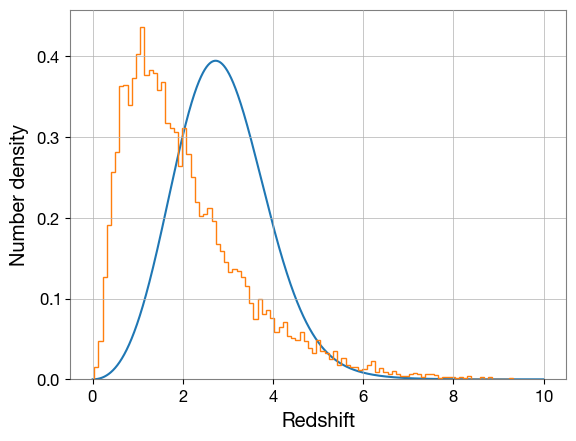

In [36]:
# plot
fig, ax = plt.subplots()
ax.plot(zl_arr, zl_pdf_values)
ax.hist(ler.lens_redshift_SDSS_catalogue(10*np.ones(10000)), density=True, bins=100, histtype='step')  
ax.set_xlabel('Redshift')
ax.set_ylabel('Number density')
plt.show()


In [1]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution
from ler.utils import get_param_from_json, rejection_sample
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

import numpy as np
import matplotlib.pyplot as plt

Setting multiprocessing start method to 'fork'


In [26]:
ler = LensGalaxyParameterDistribution()

z_to_luminosity_distance interpolator will be loaded from ./interpolator_pickle/z_to_luminosity_distance/z_to_luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_0.pickle
merger_rate_density interpolator will be loaded from ./interpolator_pickle/merger_rate_density/merger_rate_density_0.pickle
z_to_Dc interpolator will be loaded from ./interpolator_pickle/z_to_Dc/z_to_Dc_0.pickle
Dc_to_z interpolator will be loaded from ./interpolator_pickle/Dc_to_z/Dc_to_z_0.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_1.pickle
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion_ewoud/velocity_d

In [20]:
# scipy kde
import scipy.stats as stats

y_array = np.linspace(0.001, 10, 10)
x_size = 100
x_list = []
z_list = []
for i, y in enumerate(y_array):
    x_sample = ler.sample_lens_redshift(y*np.ones(x_size))
    # find kde
    kde = stats.gaussian_kde(x_sample)
    x_array = np.linspace(0.0, y, x_size)
    z_array = kde(x_array) 
    z_array /= np.max(z_array)
    x_list.append(x_array)
    z_list.append(z_array)
x_array = np.array(x_list)
z_array = np.array(z_list)
del x_list, z_list

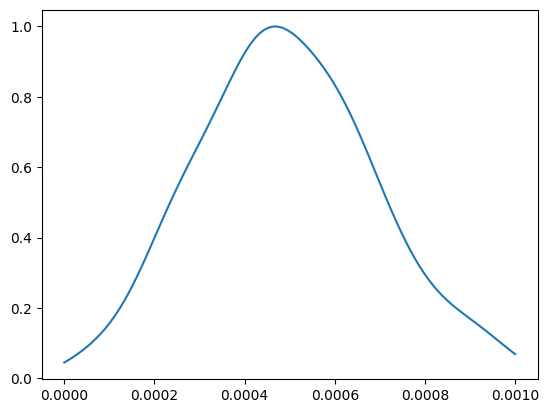

In [24]:
plt.plot(x_array[0], z_array[0], label='y={}'.format(y))

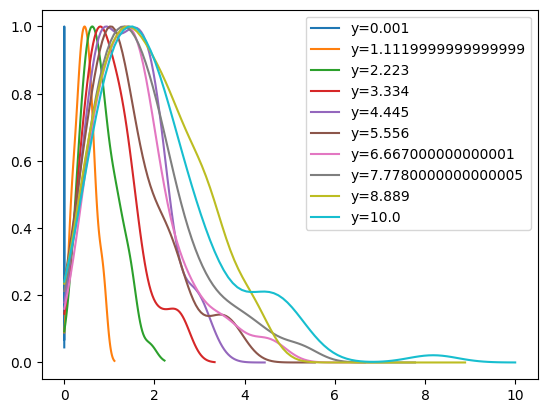

In [25]:
plt.figure()
for i, y in enumerate(y_array):
    plt.plot(x_array[i], z_array[i], label='y={}'.format(y))
plt.legend()
plt.show()

In [ ]:
class FuntionConditioning():

    def __init__(self,
        function,  # can also be an array of function values 
        x_array,
        conditioned_y_array=None,  # if this is not none, 2D interpolation will be used
        param_dict_given={},
        directory='./interpolator_pickle',
        sub_directory='default',
        name='default',
        create_new=False,
        create_function=True,
        create_inverse_function=True,
        create_pdf=True,
        create_cdf=True,
        create_rvs=True,
    ):

        # create_interpolator input list
        input_list = [function, x_array, conditioned_y_array, create_function, create_inverse_function, create_pdf, create_cdf, create_rvs]

        # check first whether the directory, subdirectory and pickle exist
        path_inv_cdf, it_exist = interpolator_pickle_path(
            param_dict_given=param_dict_given,
            directory=directory,
            sub_directory=sub_directory,
            interpolator_name=name,
        )

        # if the interpolator exists, load it
        if create_new:
            it_exist = False

        if it_exist:
            print(f"{name} interpolator will be loaded from {path_inv_cdf}")
            # load the interpolator
            interpolator = get_param_from_json(path_inv_cdf)
        else:
            print(f"{name} interpolator will be generated at {path_inv_cdf}")
            interpolator = self.create_interpolator(*input_list)

        self.function_spline = interpolator['function_spline']
        # self.pdf = interpolator['pdf']
        # self.cdf = interpolator['cdf']
        # self.rvs = interpolator['rvs']
        self.x_array = interpolator['x_array']
        self.conditioned_y_array = interpolator['conditioned_y_array']

    def create_interpolator(self, function, x_array, conditioned_y_array, create_function, create_inverse_function, create_pdf, create_cdf, create_rvs):

        # function can be numpy array or callable
        # x_array, z_array are 2D arrays if conditioned_y_array is not None
        x_array, z_array, conditioned_y_array = self.create_z_array(x_array, function, conditioned_y_array)
        del function

        # 1D or 2D function
        if conditioned_y_array is None:

            function_spline = self.function_creator_1d(x_array, z_array) if create_function else None
            # inverse_function_spline = self.function_creator_1d(z_array, x_array) if create_inverse_function else None
            # pdf_spline = self.pdf_creator_1d(x_array, z_array) if create_pdf else None
            # cdf_spline = self.cdf_creator_1d(x_array, z_array) if create_cdf else None
            # rvs_spline = self.rvs_creator_1d(x_array, z_array) if create_rvs else None

        else:
            function_spline = self.function_creator_2d(x_array, z_array, conditioned_y_array) if create_function else None
            
        return {
            'x_array': x_array,
            'conditioned_y_array': conditioned_y_array,
            'function_spline': function_spline,
        }

    def create_z_array(self, x_array, function, conditioned_y_array):

        if callable(function):
            if conditioned_y_array is None:
                z_array = function(x_array)
                # remove nan values
                idx = np.argwhere(np.isnan(z_array))
                x_list = np.delete(x_array, idx)
                z_list = np.delete(z_array, idx)

            else:
                idx = np.argsort(conditioned_y_array)
                conditioned_y_array = conditioned_y_array[idx]
                # x_array is 2D here, each row corresponds to a different y value
                x_array = x_array[idx]

                z_list = []
                x_list = []
                for i, y in enumerate(conditioned_y_array):
                    x_ = np.sort(x_array[i])
                    try:
                        z_ = function(x_, y)
                    except:
                        z_ = function(x_, y*np.ones_like(x_))

                    idx = np.argwhere(np.isnan(z_))
                    x_list.append(np.delete(x_, idx))
                    z_list.append(np.delete(z_, idx))

        else:
            if conditioned_y_array is None:
                z_array = function
                # remove nan values
                idx = np.argwhere(np.isnan(z_array))
                x_list = np.delete(x_array, idx)
                z_list = np.delete(z_array, idx)
            else:
                # row sort
                idx = np.argsort(conditioned_y_array)
                conditioned_y_array = conditioned_y_array[idx]
                # x_array is 2D here, each row corresponds to a different y value
                x_array = x_array[idx]
                z_array = function[idx]

                z_list = []
                x_list = []
                for i in range(len(conditioned_y_array)):
                    # column sort
                    idx = np.argsort(x_array[i])
                    x_ = x_array[i][idx]
                    z_ = z_array[i][idx]
                    idx = np.argwhere(np.isnan(z_))
                    x_list.append(np.delete(x_, idx))
                    z_list.append(np.delete(z_, idx))


        return x_list, z_list, conditioned_y_array


    def function_creator_1d(self, x_array, z_array):

        return CubicSpline(x_array, z_array).c

    def function_creator_2d(self, x_array, z_array, conditioned_y_array):

        function_spline = []
        for i, y in enumerate(conditioned_y_array):
            function_spline.append(self.function_creator_1d(x_array[i], z_array[i]))
            
        return function_spline
